In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import sklearn.neural_network

import time
from tqdm import tqdm
import progressbar

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [39]:
diamonds_df = pd.read_csv('data/diamonds.csv')

In [40]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


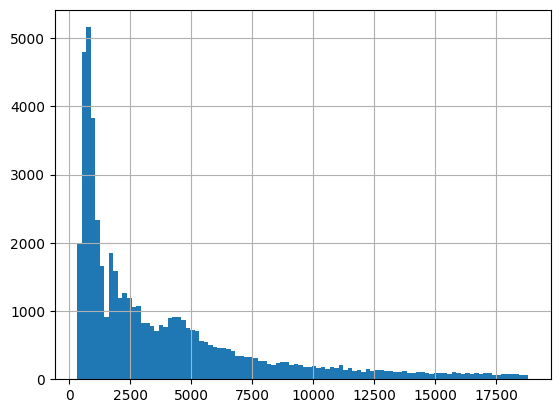

In [41]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [42]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [43]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [44]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [45]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [46]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [48]:
reg = LinearRegression().fit(X_train, y_train)

In [49]:
y_pred = reg.predict(X_test)

In [50]:
score = r2_score(y_pred, y_test)

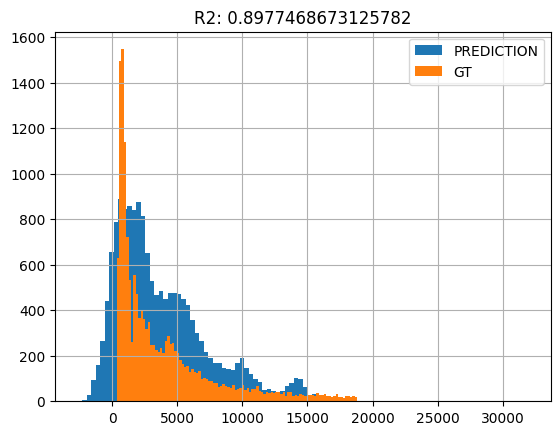

In [52]:
plt.title(f'R2: {str(score)}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

* Для активатора есть отдельный класс, где в конструкторе инициализация типа активатора(не все реализованы)

* Слой, задаются границы, задается активатор слоя, скорость обучения

* MLPRegressor реализован алгоритм прямого прохода и обратного, опирался на [sklearn](https://github.com/scikit-learn/scikit-learn/blob/f5aac2173/sklearn/neural_network/_multilayer_perceptron.py#L1261)

In [84]:
class Activation:
    def __init__(self, codeActivation: str = 'sigmoid', alpha: float = 0.0):
        '''
        Источник: https://habr.com/ru/articles/727506/
        '''
        assert (alpha >= 0.0), f'Альфа меньше 0: {alpha}'
        assert (codeActivation in ['relu', 'leakedrelu', 'sigmoid', 'linear']), f'''
            Не корректная функция: {codeActivation}'''

        self._alpha = alpha
        self._codeActivation = codeActivation

    def _sigmoid(self, x: np.ndarray):
        return 1.0 / (1.0 + np.exp(-x))

    def __call__(self, x: np.ndarray):
        if self._codeActivation == 'relu' or self._codeActivation == 'leakedrelu':
            return np.where(x > 0.0, x, self._alpha * x)
        elif self._codeActivation == 'sigmoid':
            return self._sigmoid(x)
        elif self._codeActivation == 'linear':
            return x

    def derivative(self, x: np.ndarray):
        if self._codeActivation == 'relu' or self._codeActivation == 'leakedrelu':
            return np.where(x > 0.0, 1.0, self._alpha)
        elif self._codeActivation == 'sigmoid':
            return self._sigmoid(x) * (1 - self._sigmoid(x)) 
        elif self._codeActivation == 'linear':
            return 1

In [85]:
class Layer:
    '''
    Класс для описания слоя нейронной сети
    Атрибуты
    --------
    public:
        biases : np.ndarray
            Предупреждения
        db : np.ndarray
            Диференциал предупреждения
        weights : np.ndarray
            Веса
        dw : np.ndarray
            Диференциал весов
    private:
        _learning_rate : float
            Скорость обучения
        _activation : Activation
            Активатор
        _count : int
            Подсчет прохода
        _input : np.ndarray
            Входные нейроны
    Методы
    ------
        forward - прямой проход ~~Как я понимаю, это стандартное название~~
            inp - input - входные значения
        backward - обратный проход
            error - ошибка по который калибровать
            prev_out - Предыдущие значения
        __call__ - обновление весов
    '''
    def __init__(self, prev_size: int, size: int, learning_rate: float, activation: Activation):
        self._learning_rate = learning_rate
        self._activation = activation
        self._count = 0

        self.biases = np.random.rand(size).reshape(-1, 1) / 10.0
        self.db = np.zeros_like(self.biases)

        if prev_size is not None and prev_size != 0:
            self.weights = np.random.rand(size, prev_size) / 10.0
            self.dw = np.zeros_like(self.weights)

    def forward(self, inp: np.ndarray):
        self._input = (self.weights * inp + self.biases) if inp.ndim == 0 \
            else (self.weights @ inp + self.biases)
        return self._activation(self._input)

    def backward(self, error: np.ndarray, prev_out: np.ndarray):
        self._count += 1
        neurons = (error.reshape(-1, 1) * self._activation.derivative(self._input)).reshape(-1)

        self.dw += np.outer(neurons, prev_out)
        self.db += neurons.reshape(-1, 1)
        return (self.weights.T @ neurons)

    def __call__(self):
        '''
        Обновление весов,
        м-д сделал функтором, так как метод для прямого и обратного прохода очевидны,
        и остается только обновление весов
        '''
        self.weights -= self._learning_rate * self.dw / self._count
        self.biases -= self._learning_rate * self.db / self._count

        self.dw = np.zeros_like(self.dw)
        self.db = np.zeros_like(self.db)
        self._count = 0

In [86]:
class MLPRegressor:
    '''
    Multi-Layer Perceptron Regressor    
    Атрибуты
    --------
    public:
        Нету
    private:
        _outputs : np.ndarray
            Выходные слои
        _x/y_mean : float
            Среднее значение по x и y
    Методы
    ------
    В некоторые методы вставлял проверки
    
    private:
        _loss - Квадратичная функция ошибки
        _lossDerivative - Произоводная _loss
        _forward - Прямой проход
        _backward - Обратный проход
        _updateWeights - обновление весов
        _initKnowingSizes - инициализация весов
        _forward_backward - метод прямого и обратного прохода
        _mean - усредненное значение
    public:
        train ~ fit
        predict
    '''
    
    def __init__(
        self,
        hidden_layer_sizes: tuple = (100,),           # Колличество нейронов/слоев
        activation: tuple = (Activation('sigmoid'),), # *функция активации*
        learning_rate: float = 0.001,                 # Скорость обучения
        max_iter: int = 200,                          # Максимальное колличество итерация
        batch: int = 10                               # Размер мини-пакетов, для обновления весов
    ):
        '''
        Сделал так, что можно для каждого слоя задать собственную функцию 
        перехода, либо что одна для всех будет. Читал, что в
        зависимости от слоя разные стоит применять.
        '''
        for a in activation:
            assert (type(a) == type(Activation())), f'Некорректный тип введен: {type(a)}'
        assert (len(activation) == len(hidden_layer_sizes) or len(activation) == 1), f'''
            Ошибка длины: {len(activation)} != {len(hidden_layer_sizes)} or {len(activation)} != 1'''

        self._learning_rate = learning_rate # Скорость обучения
        self._max_iter = max_iter           # Максимальное колличество итерация
        self._batch = batch                 # Размер мини-пакетов, для обновления весов
        self._layers = []                   # Слои
        self._input_size = None             # Входной размер
        self._output_size = None            # Выходной размер

        self._layers.append( Layer(None, hidden_layer_sizes[0], learning_rate, activation[0]) )
        if len(hidden_layer_sizes) == 1:
            return
        
        if len(activation) == 1:  # Если у нас 1 единый активатор
            for prev_size, curr_size in zip(hidden_layer_sizes, hidden_layer_sizes[1:]):
                self._layers.append(Layer(prev_size, curr_size, learning_rate, activation[0]))
        else: # Если на каждый слой есть активатор
            i = 1
            for prev_size, curr_size in zip(hidden_layer_sizes, hidden_layer_sizes[1:]):
                self._layers.append(Layer(prev_size, curr_size, learning_rate, activation[i]))
                i += 1

    def _loss(self, actual, predicted):
        '''
        Квадратичная функция ошибки
        '''
        return (actual - predicted) ** 2
    
    def _lossDerivative(self, actual, predicted):
        '''
        Производная квадратичная функция ошибки
        '''
        return -2 * (actual - predicted)
    
    def _forward(self, inp: np.ndarray, train: bool = False):
        assert inp.ndim == 1 or inp.ndim == 0, f'Измерения должны быть 1 or 0, ndim = {inp.ndim}'
        last_layer = inp.reshape(-1, 1)
        self._outputs = [inp] if train else self._outputs
        for layer in self._layers:
            last_layer = layer.forward(last_layer)
            if train:
                self._outputs.append(last_layer)
        return last_layer.reshape(-1)

    def _backward(self, actual, predicted):
        error = self._lossDerivative(actual, predicted)
        for i in range(len(self._layers) - 1, -1, -1): # Обратный проход
            error = self._layers[i].backward(error, self._outputs[i])

    def _updateWeights(self):
        '''
        Обновление весов в слоях
        '''
        for i in range(len(self._layers) - 1, -1, -1):
            self._layers[i]()

    def _mean(self, x, y):
        '''
        Нормализация значений, создаем копию еще, чтобы исходные
        данные не повредить, был баг почему то с этим. . .
        '''
        self._x_mean = x.mean()
        _x = (x / self._x_mean).copy()
        self._y_mean = y.mean()
        _y = (y / self._y_mean).copy()
        return _x, _y

    def _initKnowingSizes(self, x, y):
        '''
        Инициализация 
        '''
        self._input_size = 1 if x.ndim == 1 else x.shape[1]
        self._layers[0].weights = (np.random.rand(self._layers[0].biases.size, self._input_size) / 10)
        self._layers[0].dw = np.zeros_like(self._layers[0].weights)

        self._output_size = 1 if y.ndim == 1 else y.shape[1]
        self._layers.append(Layer(self._layers[-1].biases.size, self._output_size,
                                  self._learning_rate, Activation('linear')))

    def _forward_backward(self, _x, _y):
        '''
        Метод объединяющий метод прямого прохода и метод обратного прохода
        '''
        losses = []
        for _ in tqdm(range(self._max_iter)):
            i = 0
            losses_buf = []
            for inp, actual in zip(_x, _y):
                i += 1
                predicted = self._forward(inp, True)
                self._backward(actual, predicted)
                losses_buf.append(self._loss(actual, predicted) * self._y_mean)
                if i % self._batch == 0:
                    self._updateWeights()
                if i % int(_x.shape[0] / 10) == 1:
                    losses.append(sum(losses_buf) / len(losses_buf))
                    losses_buf = []
    
    def train(self, x: np.ndarray, y: np.ndarray):
        if self._input_size is not None:
            assert (self._input_size == (1 if x.ndim == 1 else x.shape[-1])), """
                Входное значение другое от предыдущего значения!"""
            assert (self._output_size == (1 if y.ndim == 1 else y.shape[-1])), """
                Выходное значение другое от предыдущего значения!"""
        else:
            self._initKnowingSizes(x, y)
        _x, _y = self._mean(x, y)
        self._forward_backward(_x, _y)
        

    def predict(self, x: np.ndarray):
        assert self._input_size is not None, 'Обучения не было'
        assert (self._input_size == (1 if x.ndim == 1 else x.shape[-1])), f'''
            Размер входных отличается от ожидаемых {self._input_size}'''
        
        # Нормализация значений, создаем копию еще, чтобы исходные
        # данные не повредить, был баг почему то с этим. . .
        _x = (x / self._x_mean).copy()
        return np.array([self._forward(inp) for inp in _x] if x.ndim == 2 or (x.ndim == 1 \
            and self._input_size == 1) else self._forward(_x)) * self._y_mean

# Проверяем модель MLP на выборке Diamonds

## Наша реализация

In [92]:
model = MLPRegressor(
            hidden_layer_sizes=(50, 25, 5),
            activation=(Activation('leakedrelu'),),
            max_iter=10,
        )

In [93]:
model.train(X_train, y_train)

100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


In [94]:
y_pred_my = model.predict(X_test)

In [95]:
score_my = r2_score(y_pred_my, y_test)

## sklearn

In [23]:
model = sklearn.neural_network.MLPRegressor(solver='adam')

In [24]:
model.fit(X_train, y_train.ravel())

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [25]:
y_pred_sklearn = model.predict(X_test)

In [26]:
score_sklearn = r2_score(y_pred_sklearn, y_test)

## График

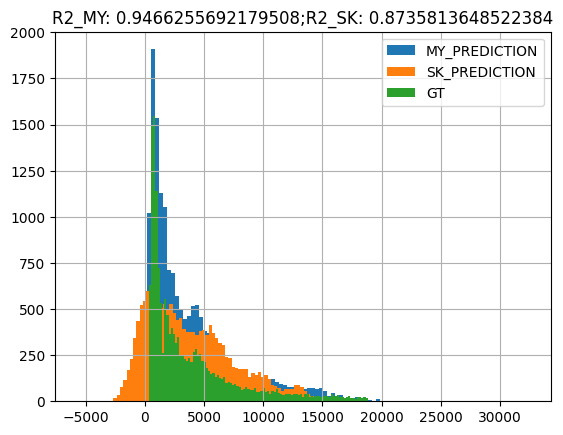

In [96]:
plt.title(f'R2_MY: {str(score_my)};R2_SK: {str(score_sklearn)}')
plt.hist(y_pred_my.reshape(1, -1)[0], bins=100, label='MY_PREDICTION')
plt.hist(y_pred_sklearn.reshape(1, -1)[0], bins=100, label='SK_PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();